In [3]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# LIBRARIES

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import time
import scipy

#Separate import for numpy and jax.numpy to have major felxibility
import jax.numpy as jnp
import numpy as np
from jax import jit,lax,random
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions
from tensorflow_probability.substrates import jax as jtfp
jtfd = jtfp.distributions

np.random.seed(0)

# LOAD DATA

In [2]:
sampled_perturbed = np.load('sampled_2D_two_clusters.npy')

In [3]:
data = sampled_perturbed[0 : 1000]

In [4]:
#DEFINING NUMBER OF CLUSTERS AND DIMENSION OF DATA
k = 10
d = 2
#Key to store for random generation
rng_key = random.PRNGKey(0)

# GIBBS SAMPLER

In [5]:


def run_one_gibbs(data, cluster_allocs, uniq_vals, weights, alpha, lam , key):
    
    """
    Run one gibbs sampler iteration
    Takes in input values of the previous iteration and sample the new values from sample_uniq_vals_fullcond, update_weights and update_cluster_allocs
    Returns:   
    
    -cluster_allocs: for every data point, the cluster assigned
    -uniq_vals: array of parameters of the distributions. Matrix has d rows of the type:[mu[0], var[0,0], var[0,1]]
    -weights: array with the weights of the clusters 
     """
    
    n_clus = len(weights)
    
    for h in range(n_clus):
        
        #Extract data assigned to cluster h and sample 
        clusdata = data[cluster_allocs == h]
        if len(clusdata) != 0:
            uniq_vals[h, :],key = sample_uniq_vals_fullcond_Wasserstein(clusdata, lam, uniq_vals, h, key)
        else:
            uniq_vals[h, :],key = sample_uniq_vals_prior(lam, uniq_vals[h, :], key)
    
    #I pass weights to make sure i can compute n_clus (otherwise JAX gives problem with for loop)
    weights,key = update_weights(cluster_allocs ,alpha,weights,key)
    
    cluster_allocs,key = update_cluster_allocs(data, weights, uniq_vals,key)
    
    return cluster_allocs, uniq_vals, weights, key




def run_mcmc(data, k,  key , niter=2500, nburn=500, thin=5 ): 
    
    """
    Runs entire MCMC
    Takes in input data, number of clusters, number of iterations, burn-in and thin
    Returns the parameters recorded after burn-in phase
    """
    
    b = time.time() # only to measure time
    
    
    #Priors
    cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
    weights = np.ones(k)/k
    alpha = 0.1
    lam = 0.1
    uniq_vals = np.dstack([
        tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(np.ones(d))/lam)).sample(k),
        tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k)])
    
    #Output values
    allocs_out = []
    uniq_vals_out = []
    weights_out = []
    
    #Useful value
    data_mean = jnp.mean(data, axis = 0)
    
    #Iterations
    for i in range(niter):
        cluster_allocs, uniq_vals, weights , key = run_one_gibbs(
            data, cluster_allocs, uniq_vals, weights, alpha, lam , key)
        
        if i > nburn and i % thin == 0:
            allocs_out.append(cluster_allocs)
            uniq_vals_out.append(uniq_vals.copy())
            weights_out.append(weights)
            
        if i % 10 == 0:
            a = time.time()
            print("\rIter {0} / {1}".format(i+1, niter) + " Remaining minutes: " + str(round((a-b)*(niter-i)/(60*10) ,1)) , flush=False, end=" ")
            b = time.time()
            
    return allocs_out, uniq_vals_out, weights_out,key

# Full Conditionals and Utilities

In [76]:
def sample_uniq_vals_fullcond_Wasserstein(clusdata, lam, uniq_vals, h, key):
    """
    Perform one step of the Metropolis Hastings step to sample a couple (mu,cov) from NIW*Wasserstein
    """
    
    #Starting point of MH
    mu_old = np.array([uniq_vals[h,0,0], uniq_vals[h,1,0]])
    cov_old = np.array([[uniq_vals[h,0,1], uniq_vals[h,0,2]], 
                        [uniq_vals[h,1,1], uniq_vals[h,1,2]]])
    
    # Compute the parameters of the updated NIW
    mu_n, lam_n, phi_n, nu_n = compute_param_conjugate_NIW(clusdata, lam)
    
    # Sample the proposal from NIW
    mu, cov = sample_from_NIW(mu_n, lam_n, phi_n, nu_n)
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta(uniq_vals, h, mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old)
    print(beta)
    accept_rate = np.min(1, beta)
    draw = tfd.Bernoulli(probs = accept_rate).sample()
    
    # Select the new or old values without an if to help JAX implementation
    mu = draw * mu + (1 - draw) * mu_old
    cov = draw * cov + (1 - draw) * cov_old
    
    
    return np.array([[mu[0], cov[0,0], cov[0,1]],[mu[1], cov[1,0], cov[1,1]]]) , accept_rate


def compute_param_conjugate_NIW(clusdata, lam):
    """
    Compute parameters for the conjugate NIW distribution
    """
    n=len(clusdata)
    mean_clus = np.mean(clusdata, axis = 0)
    mean_data = np.mean(data, axis = 0)
    
    W0 = np.diag(np.ones(d))
    C = (n-1)*np.cov(clusdata, rowvar = False)
    D = lam*n/(lam+n)*np.dot(mean_clus - mean_data, mean_clus - mean_data)
    phi_n = (W0 + C + D)
    
    nu_n = d +n
    lam_n = lam + n
    mu_n = (lam * mean_data + n * mean_clus)/(lam+n)
    return mu_n, lam_n, phi_n, nu_n

def sample_from_NIW(mu_n, lam_n, phi_n, nu_n):
    """
    Sample from a NIW given its parameters
    """
    W = np.linalg.inv(phi_n)
    chol = np.linalg.cholesky(W) 
    prec = tfd.WishartTriL(df=nu_n, scale_tril=chol).sample()
    
    cov = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance(mu_n, cov/(lam_n)).sample()
    return mu, cov

def evaluate_NIW(x_mu, x_cov, mu_n, lam_n, phi_n, nu_n):
    """
    Evaluate the likelihood given the parameters of a NIW
    """
    W = np.linalg.inv(phi_n)
    chol = np.linalg.cholesky(W) 
    inv_cov = np.linalg.inv(x_cov)
    
    f1 = tfd.WishartTriL(df=nu_n, scale_tril=chol).prob(inv_cov)
    f2 = tfd.MultivariateNormalFullCovariance(mu_n, x_cov/(lam_n)).prob(x_mu)
    return f1 * f2

def compute_Wasserstein(mu_1, cov_1, mu_2, cov_2):
    """
    Wasserstein distance for the Gaussian Case
    """

    norm = np.linalg.norm(mu_1 - mu_2, ord = 2)
    sqrt_C2 = scipy.linalg.sqrtm(cov_2)
    print("sqrt_C2: " + str(sqrt_C2))
    C1_sqrt_C2 = np.dot(cov_1,sqrt_C2)
    sqrt_C2_C1_sqrt_C2 = np.dot(sqrt_C2,C1_sqrt_C2)
    trace = np.trace(cov_1 + cov_2 - 2 * scipy.linalg.sqrtm(sqrt_C2_C1_sqrt_C2))

    return norm + trace

def compute_beta(uniq_vals, h, mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old):
    """
    Compute the beta term in the MH algorithm
    """
    # Following https://en.wikipedia.org/wiki/Normal-Wishart_distribution notation, 
    # we choose as proposal a NIW with mu_0 the old mean, W the old cov/nu ,
    # lambda and nu to be tuned for the acceptance ratio
    
    nu_prop = 2
    lambda_prop = 0.1
    
    
    # Target distribution terms
    num_1 = evaluate_NIW(mu, cov, mu_n, lam_n, phi_n, nu_n)
    den_1 = evaluate_NIW(mu_old, cov_old , mu_n, lam_n, phi_n, nu_n)
    
    # Proposal distribution terms: CHECK
    print("Check that proposal is correct in compute_beta")
    prop_num = evaluate_NIW(mu_old , cov_old , mu_n , lambda_prop , phi_n , nu_prop)
    prop_den = evaluate_NIW(mu , cov , mu_n , lambda_prop , phi_n , nu_prop)
    
    # Wasserstein Distances
    prod = 1
    for j in range(k):
        if(j != k):
            mu_k = np.array([uniq_vals[j,0,0],uniq_vals[j,1,0]])
            cov_k = np.array( [uniq_vals[j,0,1:3] , uniq_vals[j,1,1:3]]  )
            print("----")
            print("mu_k: " + str(mu_k))
            print("cov_k: " + str(cov_k))
            print(compute_Wasserstein(mu , cov , mu_k , cov_k))
            print(compute_Wasserstein(mu_n , phi_n , mu_k, cov_k))
            print("----")
            prod = prod * compute_Wasserstein(mu , cov , mu_k , cov_k) / compute_Wasserstein(mu_n , np.linalg.inv(phi_n) , mu_k, cov_k)
    

    print("prod: " + str(prod))
    print("num_1" + str(num_1))
    print("prop_num" + str(prop_num))
    print("den_1" + str(den_1))
    print("prop_den" + str(prop_den))
 

    return num_1 * prop_num * prod / (den_1 * prop_den)


In [ ]:
mu1 = np.array([-0.38523929  0.24638733])
cov1 = np.array([[ 0.94447372 -1.99694968],[-1.99694968  4.25242847]])
compute_Wasserstein()

In [77]:
#RUNNING THE MCMC
start = time.time()
allocs_out, uniq_vals_out, weights_out,key = run_mcmc(data, k , rng_key)
end = time.time()
print("Total time: " + str(end-start))

#Around 1 minutes instead of 15, 15x speedup :) 

Check that proposal is correct in compute_beta
----
mu_k: [-0.46416464 -0.804352  ]
cov_k: [[ 5.70643228 -6.9221736 ]
 [-6.9221736   9.06155774]]
sqrt_C2: [[ 1.77171285 -1.60233139]
 [-1.60233139  2.54835081]]
67.97037179321143
sqrt_C2: [[ 1.77171285 -1.60233139]
 [-1.60233139  2.54835081]]
4871.915478194671
----
sqrt_C2: [[ 1.77171285 -1.60233139]
 [-1.60233139  2.54835081]]
sqrt_C2: [[ 1.77171285 -1.60233139]
 [-1.60233139  2.54835081]]
----
mu_k: [-0.28956647  0.11469919]
cov_k: [[ 5.39518372 -1.4919911 ]
 [-1.4919911   2.70806576]]
sqrt_C2: [[ 2.29088819 -0.38342536]
 [-0.38342536  1.60032833]]
49.92730670831472
sqrt_C2: [[ 2.29088819 -0.38342536]
 [-0.38342536  1.60032833]]
4770.006493909337
----
sqrt_C2: [[ 2.29088819 -0.38342536]
 [-0.38342536  1.60032833]]
sqrt_C2: [[ 2.29088819 -0.38342536]
 [-0.38342536  1.60032833]]
----
mu_k: [-0.11051057  0.41070056]
cov_k: [[2.88930026 1.09715644]
 [1.09715644 1.37070165]]
sqrt_C2: [[1.65242451 0.39848902]
 [0.39848902 1.100867  ]]
46.867

/Users/leopere/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in double_scalars


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [67]:
cov = np.array([[ 4.15968048, -1.50960413],[-1.50960413 , 3.89325147]])
np.sqrt(cov)
print(np.linalg.eigvals(cov))
np.sqrt(cov)

[5.54193644 2.51099551]


/Users/leopere/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/leopere/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


array([[2.03952948,        nan],
       [       nan, 1.9731324 ]])

# Single functions Speed Comparison

In [ ]:
#Data to use for comparison
cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
weights = np.ones(k)/k
alpha = 0.1
lam = 0.1
clusdata = data[cluster_allocs == 2]
uniq_vals = np.dstack([
    tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(np.ones(d))/lam)).sample(k),
    tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k)])
key = rng_key
n_clus = 10

%timeit sample_uniq_vals_fullcond(clusdata,lam,key)
%timeit sample_uniq_vals_fullcond_slow(clusdata,lam)
%timeit update_weights(cluster_allocs, alpha,weights,key)
%timeit update_weights_slow(cluster_allocs, n_clus, k, alpha)
%timeit update_cluster_allocs(data, weights, uniq_vals,key)
%timeit update_cluster_allocs_slow(data, weights, uniq_vals)
%timeit sample_uniq_vals_prior(lam,key)
%timeit sample_uniq_vals_prior_slow(lam)

# PLOT OF THE CLUSTERS

6    496
2    403
8    101
dtype: int64


<BarContainer object of 3 artists>

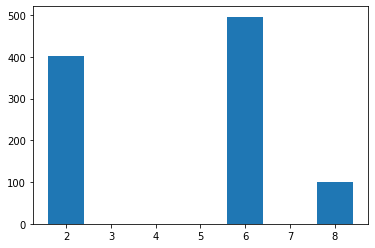

In [13]:
#View the number of points inside each cluster at the final iteration
print(pd.Series(allocs_out[-1]).value_counts())

x, y = np.unique(allocs_out[-1], return_counts=True)


plt.bar(x, y)


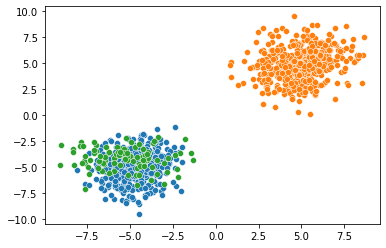

In [14]:
#scatterplot of clusters from last iteration
for h in range(k):
    currd = data[allocs_out[-1] == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd])

ValueError: The palette list has the wrong number of colors.

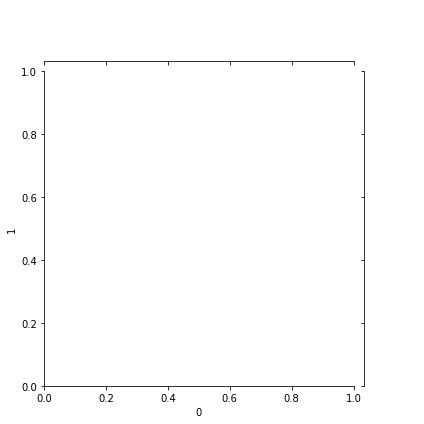

In [15]:
#scatterplot of clusters with marginal distributions
data1=pd.DataFrame(data)
data1["allocs"]=allocs_out[-1]
sns.jointplot(data=data1,x=data1[0],y=data1[1], hue="allocs",palette=sns.color_palette("hls", 4))

In [16]:
#MEDIE NEI CLUSTER DELL'ULTIMA ITERAZIONE
M = [[np.mean(data[allocs_out[-1] == h][:,0]), np.mean(data[allocs_out[-1] == h][:,1])] for h in [5,8,9]]
M=pd.DataFrame(M)


/Users/leopere/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/leopere/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# TRACE PLOTS

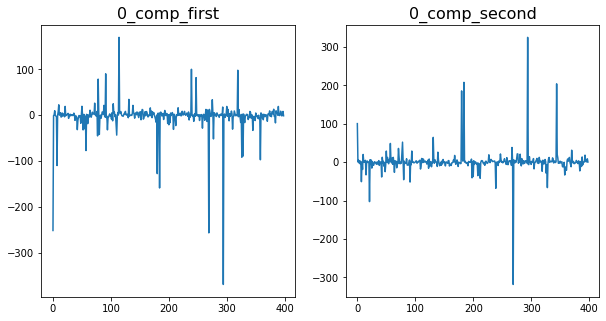

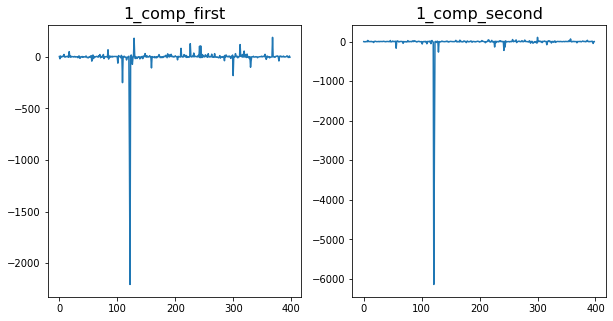

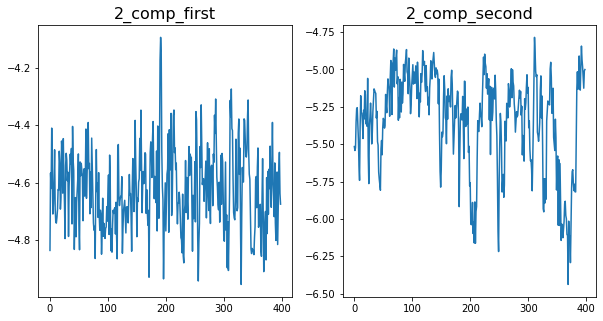

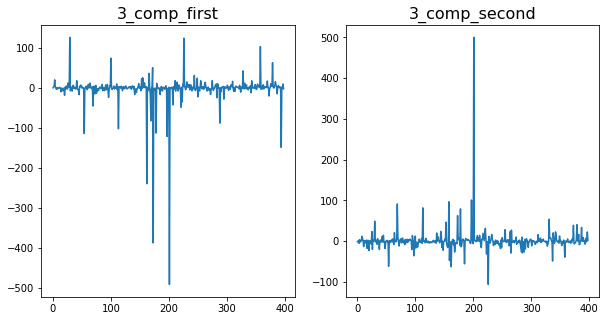

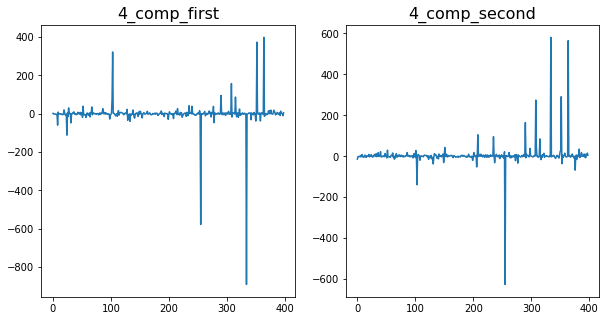

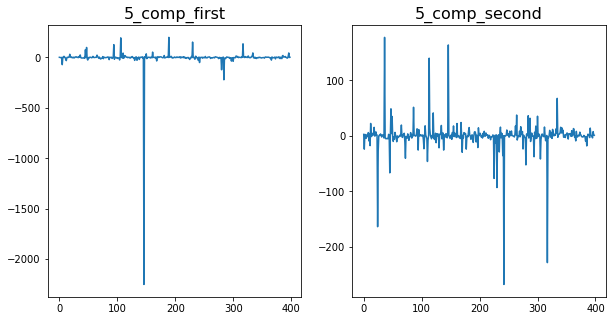

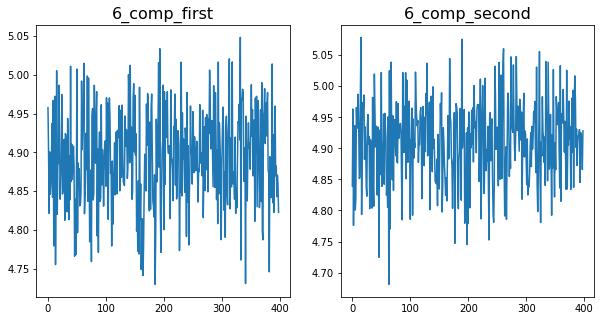

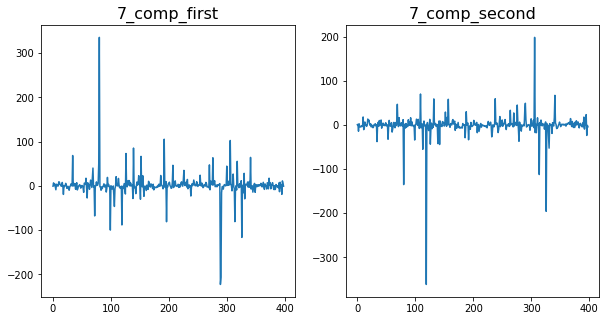

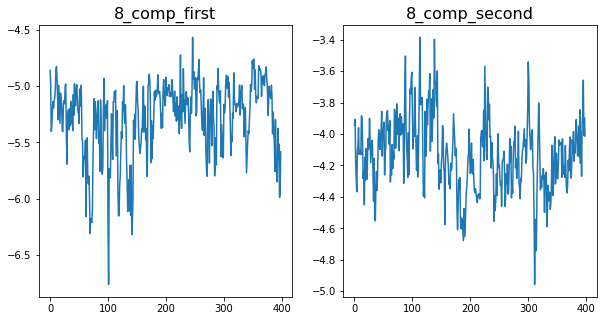

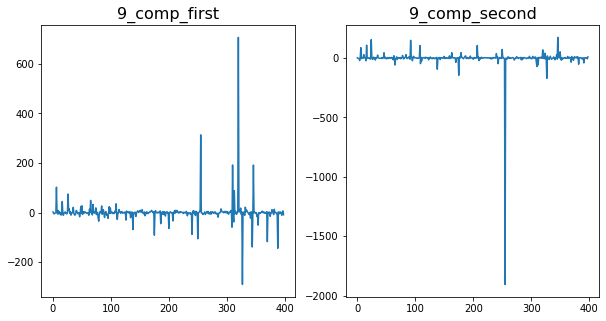

In [16]:
means = [val[:,:,0] for val in uniq_vals_out]
for i in range(len(weights_out[0])):
    

    #Get mean of i-th gaussian component
    first_comp = [mean[i,:] for mean in means]

    #Get mu_1 and mu_2 from the i-th component (multivariate) mean
    first_comp_first = [first_comp_mean[0] for first_comp_mean in first_comp]
    first_comp_second = [first_comp_mean[1] for first_comp_mean in first_comp]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes[0].plot(np.arange(len(first_comp_first)), first_comp_first)
    axes[0].set_title(str(i) + "_comp_first", fontsize=16)

    axes[1].plot(np.arange(len(first_comp_second)), first_comp_second,)
    axes[1].set_title(str(i) + "_comp_second", fontsize=16)

    plt.show()

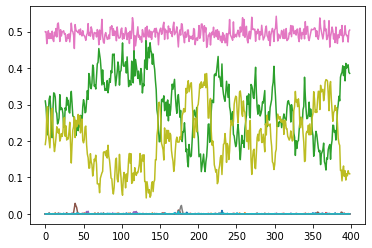

In [17]:
#Weights plot
fig,ax = plt.subplots(1)
for i in range(k):
    ax.plot(np.arange(len(weights_out)), [weight[i] for weight in weights_out])
    
plt.show()

# BEST CLUSTER

In [18]:
#Find best clustering obtained during the MCMC using the Binder Loss 

def get_psm(clus_alloc_chain):
    """
    Returns the posterior similarity matrix, i.e.
        out[i, j] = P(c_i == c_j | all the rest)
    for each pair of observations
    """
    #Fare confronto tra colonna i e j della matrice e poi calcolare da li
    c_chain = np.vstack(clus_alloc_chain)
    out = np.zeros((c_chain.shape[1], c_chain.shape[1]))
    for i in range(c_chain.shape[1]):
        for j in range(c_chain.shape[1]):
            out[i,j] = np.sum(c_chain[:,i] == c_chain[:,j]) / c_chain.shape[0]
            
    return out


def minbinder_sample(clus_alloc_chain, psm):
    """
    Finds the iteration for which the Binder loss is minimized
    and returns the associated clustering
    """
    losses = np.zeros(len(clus_alloc_chain))
    c_chain = np.vstack(clus_alloc_chain)
    
    # You can either cycle through the iterations, or 
    # cycle through the entries in the PSM [i, j]
    # and vectorize the same operation for each iteration!
    
    mat = np.zeros( ( c_chain.shape[0], c_chain.shape[1]**2 ) )
    k = 0
    for i in range(c_chain.shape[1]):
        for j in range(c_chain.shape[1]):
            mat[:,k] = ( (c_chain[:,i] == c_chain[:,j]).astype(int) - psm[i,j] * np.ones(c_chain.shape[0]) ) **2
            k = k+1
    
    losses = np.sum(mat, axis = 1)
    
    best_iter = np.argmin(losses)
    return clus_alloc_chain[best_iter]



def unique_vals_given_clus(unique_vals_chain, clus_alloc_chain, best_clus,n_clus):
    #Finds the unique values associated to the best clusters obtained during MCMC
    
    c_allocs = np.stack(clus_alloc_chain)
    uniq_vals = np.stack(unique_vals_chain)
    means = uniq_vals[:, :, : , 0]
    variances = uniq_vals[:, :, : , 1:3]
    out1 = []
    out2 = []
    for h in range(n_clus):
        data_idx = np.where(best_clus == h)[0]
        uniq_vals_idx = c_allocs[:, data_idx] # -> Matrix [n_iter x n_data_in_clus]
        means_by_iter = np.empty((c_allocs.shape[0], len(data_idx),2))
        vars_by_iter = np.empty((c_allocs.shape[0], len(data_idx),2,2))
        for i in range(c_allocs.shape[0]):
            means_by_iter[i, :] = means[i,uniq_vals_idx[i,:],:]
            vars_by_iter[i, :] = variances[i,uniq_vals_idx[i,:]]

        avg_mean_by_iter = np.mean(means_by_iter , axis = 1)
        avg_var_by_iter = np.mean(vars_by_iter , axis = 1)
        
        muhat = np.mean(avg_mean_by_iter,axis=0)
        sigsqhat = np.mean(avg_var_by_iter,axis=0)
        out1.append(np.array(muhat))
        out2.append(np.array(sigsqhat))
    
    #If there are no points in certain clusters, the output would be full of NANs for the cluster. This gives problems
    #I replace the NANs with some 0
    for i in range(len(out1)):
        if(np.any(np.isnan(out1[i]))):
            out1[i] = np.zeros(shape = out1[i].shape)
        if(np.any(np.isnan(out2[i]))):
            out2[i] = np.eye(N = out2[i].shape[0])
    
        
    return out1,out2


psm = get_psm(allocs_out)
best_clus = minbinder_sample(allocs_out,psm)

mu_lis,var_lis = unique_vals_given_clus(uniq_vals_out, allocs_out, best_clus,k)
weights = np.sum(best_clus == np.arange(k)[:, np.newaxis], axis=1) / len(data)



/Users/Manuel/.virtualenvs/Bayes_Exe/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Manuel/.virtualenvs/Bayes_Exe/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


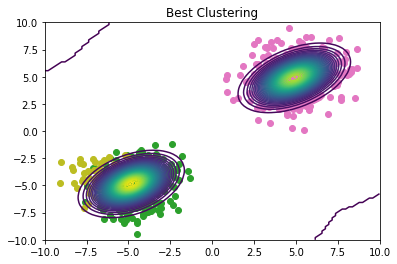

In [19]:
#Plot resulting density of the mixture

def eval_multivariate_mixture_dens(locations, variances, weights, xgrid):
    eval_comps = tfd.MultivariateNormalFullCovariance(locations, np.sqrt(variances)).prob(xgrid[:, np.newaxis])
    return np.sum(eval_comps * weights, axis=1)

grid_1D = np.linspace(-10, 10, 100)
grid_2D = np.array([[x0, y0] for x0 in grid_1D for y0 in grid_1D])
X,Y = np.meshgrid(grid_1D,grid_1D) 
fig = plt.figure()
ax = plt.axes()
ax.contour(X, Y,np.reshape(eval_multivariate_mixture_dens(mu_lis, var_lis, weights, grid_2D), newshape = X.shape) , 50, cmap='viridis')
ax.set_title('Best Clustering');
for h in range(k):
    currd = data[best_clus == h]
    ax.scatter(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd],)